In [4]:
from pymongo import MongoClient
import datetime
from dateutil import parser
import pandas as pd
from pytz import timezone

This notebook relies on a database of tweets.  By default, the database is running on the same computer where this code runs, so it is not necessary to specify the IP address of the DB.  Unless you have scraped tweets too, you will not be able to run this notebook.

In [ ]:
# Initialize mongoDB client
client = MongoClient()
db = client.retweets

The `get_time_bins` function uses a histogram approach, iterating through each tweet and then counting it towards the appropriate bin.  This is faster than several other approaches that I tried.

In [5]:
def get_time_bins(collection):
    """
    Counts number of tweets in each hour in database.  Uses hours ending at :45 becuase that's when I collected data.
    """
    # Get first and last tweet, adjust to standard 45-minute window
    first_tweet = collection.find().sort('id', 1).limit(1).next()
    first = parser.parse(first_tweet['created_at'])
    first =  datetime.datetime(year=first.year, month=first.month, day=first.day, hour=first.hour, minute=45, tzinfo=first.tzinfo) - datetime.timedelta(hours=1)
    last_tweet = collection.find().sort('id', -1).limit(1).next()
    last = parser.parse(last_tweet['created_at'])
    last =  datetime.datetime(year=last.year, month=last.month, day=last.day, hour=last.hour, minute=45, tzinfo=last.tzinfo) + datetime.timedelta(hours=1)
    # now = datetime.datetime.now(timezone('UTC'))
    # now =  datetime.datetime(year=now.year, month=now.month, day=now.day, hour=now.hour, minute=45, tzinfo=now.tzinfo)

    # Build initial data for dataframe
    num_bins = int((last - first).total_seconds()/3600)
    bin_ends = first + pd.np.arange(1, num_bins+1)*datetime.timedelta(hours=1)
    init_df = [(be, be, 0) for be in bin_ends]
    df = pd.DataFrame(init_df, columns=['first_time', 'end', 'bin_count'])

    # Place tweets into bins
    for tweet in collection.find():
        tweet_time = parser.parse(tweet['created_at']) # parse tweet time
        binno = int((tweet_time - first).total_seconds()/3600)
        if binno < 0:
            continue
        df.set_value(binno, 'bin_count', df.bin_count[binno]+1)
        if tweet_time < df.iloc[binno].first_time:
            df.set_value(binno, 'first_time', tweet_time)
    df = df[df.bin_count != 0]
    return df

Calculate tweet-time histogram for a single user

In [14]:
user = '@realDonaldTrump'
reponame = user[1:] + '_tweetsat'
collection = db[reponame]
#collection.find({'id': {'$gt': begin_id}}).sort('id', 1).limit(100).next()['created_at'] # test
bins_df = get_time_bins(collection)
bins_df.head()

,first_time,end,bin_count
0,2016-09-01 00:04:48+00:00,2016-09-01 00:45:00+00:00,8133
1,2016-09-01 01:44:40+00:00,2016-09-01 01:45:00+00:00,100
2,2016-09-01 02:44:43+00:00,2016-09-01 02:45:00+00:00,100
3,2016-09-01 03:44:37+00:00,2016-09-01 03:45:00+00:00,100
4,2016-09-01 04:44:29+00:00,2016-09-01 04:45:00+00:00,100


Convert tweet counts to rates (tweets/hour)

In [15]:
rates = bins_df['bin_count']/((bins_df['end'] - bins_df['first_time'])/pd.np.timedelta64(1, 's'))*3600
bins_df['rate'] = rates
bins_df.head()

,first_time,end,bin_count,rate
0,2016-09-01 00:04:48+00:00,2016-09-01 00:45:00+00:00,8133,12138.805970
1,2016-09-01 01:44:40+00:00,2016-09-01 01:45:00+00:00,100,18000.000000
2,2016-09-01 02:44:43+00:00,2016-09-01 02:45:00+00:00,100,21176.470588
3,2016-09-01 03:44:37+00:00,2016-09-01 03:45:00+00:00,100,15652.173913
4,2016-09-01 04:44:29+00:00,2016-09-01 04:45:00+00:00,100,11612.903226


Produce a plot of tweet rate over time.

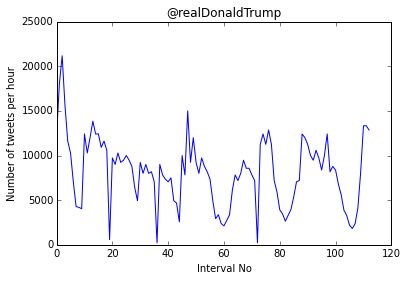

In [16]:
# Plot the rate over time
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(rates)), rates)

plt.xlabel('Interval No')
plt.ylabel('Number of tweets per hour')
plt.title(user)
plt.show()